# ExoMarsRSP SPICE Kernel Dataset Testcase 

This Jupyter Notebook is used to illustrate some examples on how to use the testcase provided in the ExoMarsRSP SKD v0.1.0. This SKD features the following scenario:

This is the first release of the ExoMarsRSP SPICE Kernel Dataset it is in draft state and it is aimed to provide the ROCC the capability to start testing SPICE in their systems. It includes a basic set of reference frames defined for the RM structures and PanCam and includes sample IKs for NavCam and PanCam, it also includes an example of an structures SPKs and several sample SPKs and CKs.

The scenario that this release covers simulates a first travel of the rover and a first observation by moving the payload bench on top of the mast by a given pan and tilt set of angles. The travel of the rover can be depicted as follows (XY plane):

            .----------------.
          .                   .
         .                     .                   +Ydisp
         |                     |                     ^
         |                     |                     |  Rover Disposal
         |                      .                    |
         |                       '.__________________o----->
         |                                                 +Xdisp
         |
         |
         |
         X End Point


The timeline of the scenario is as follows:

         2020 NOV 01 00:00:00 TDB  -  Lander Disposal
         2020 NOV 01 00:00:01 TDB  -  Drive 5 meters
         2020 NOV 01 00:01:42 TDB  -  Turn Right
         2020 NOV 01 00:02:43 TDB  -  Drive 5 meters
         2020 NOV 01 00:04:06 TDB  -  Turn Left
         2020 NOV 01 00:04:34 TDB  -  Drive 3.7 meters
         2020 NOV 01 00:05:46 TDB  -  Stop at ( -1.3e-02 -2.e-03 0 ) [km]

         2020 NOV 01 01:04:22 UTC  -  Start PTR Pan to 20 degrees
         2020 NOV 01 01:04:40 UTC  -  PTR Pan at 20 degrees
         2020 NOV 01 01:04:41 UTC  -  Start PTR Tilt to 10 degrees
         2020 NOV 01 01:04:42 UTC  -  PTR Tilt at 10 degrees

         2020 NOV 01 10:04:50 UTC  -  Start PTR Tilt to 0 degrees
         2020 NOV 01 10:10:04 UTC  -  PTR Tilt at 0 degrees
         2020 NOV 01 10:10:07 UTC  -  Start PTR Pan to 0 degrees
         2020 NOV 02 10:10:19 UTC  -  PTR Pan at 0 degrees

         2020 NOV 02 00:00:00 TDB  -  End of test scenario
         
First we load the basic Python Packages we need including SpiceyPy.

In [6]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,10)

import spiceypy as cspice
import matplotlib.pyplot as plt
import numpy as np

We now load the EMRSP meta-kernel and define a series of Time Windows that we will use to plot different quantities. We use the CSPICE FURNSH and STR2ET APIs for this purpose.

In [7]:
cspice.furnsh('/Users/mcosta/ExoMarsRSP/kernels/mk/emrsp_preops_local.tm')

start_time = '2020-11-01 00:00:00 TDB'
finish_time = '2020-11-01 23:00:00 TDB'

start_et = cspice.str2et(start_time)
finish_et = cspice.str2et(finish_time)

interval_state = np.arange(start_et, finish_et, 5.0)

start_time = '2020-11-01 00:00:00 TDB'
finish_time = '2020-11-01 00:05:00 TDB'

start_et = cspice.str2et(start_time)
finish_et = cspice.str2et(finish_time)

interval_rm = np.arange(start_et, finish_et, 5.0)

start_time = '2020-11-01 00:03:00 TDB'
finish_time = '2020-11-01 23:50:00 TDB'

start_et = cspice.str2et(start_time)
finish_et = cspice.str2et(finish_time)

interval_htc = np.arange(start_et, finish_et, 5.0)

We now loop through those time intervals to retrieve some quantities:

1-Position of the Rover w.r.t the Disposal Site (Landing Site). We use the SPICE API SPKEZR for that.

2-Angular Offset of the Rover +X axis (driving direction) w.r.t to the -X axis of the Mars Local Geodetic frame of the Disposal Site. We use the SPICE APIs PXFORM, MXV and VSEP for that.

3-We retrieve the SPICE variables for the PanCam HRC stored in SPICE, we plot them and then we calculate the Euler Angles of the rotation of the HRC boresight w.r.t. the Rover Mast. We use the SPICE APIs BODN2C, GETFOV, PXFORM and M2EUL for that purpose.

In [8]:
rm_state = []
for et in interval:

    rm_state.append(cspice.spkezr('EXOMARS ROVER',et, 'RM_MLG_DISPOSAL',
                                  'NONE', 'RM_SITE_DISPOSAL')[0])

rm_xoffset = []
for et in interval_rm:


    mat = cspice.pxform('RM_MLG_DISPOSAL', 'RM_ROVER', et)
    mlg_x  = cspice.mxv(mat, [1,0,0])
    ang = cspice.vsep(mlg_x, [1,0,0])*cspice.dpr()
    rm_xoffset.append(ang)


pancam_hrc_euler_1 = []
pancam_hrc_euler_2 = []
pancam_hrc_euler_3 = []

sensor_name = 'RM_PANCAM_HRC'

sensor_id = cspice.bodn2c(sensor_name)
(shape, frame, bsight, vectors, bounds) = cspice.getfov(sensor_id, 100)

print('{} shape:   {}'.format(sensor_name, shape))
print('{} frame:   {}'.format(sensor_name, frame))
print('{} bsight:  {}'.format(sensor_name, bsight))
print('{} vectors: {}'.format(sensor_name, vectors))
print(bounds)

for et in interval_htc:

    mat = cspice.pxform(frame, 'RM_PTR_ZERO', et)
    eul = cspice.m2eul(mat,3,2,1)
    pancam_hrc_euler_1.append(cspice.dpr()*eul[0])
    pancam_hrc_euler_2.append(cspice.dpr()*eul[1])
    pancam_hrc_euler_3.append(cspice.dpr()*eul[2])

RM_PANCAM_HRC shape:   RECTANGLE
RM_PANCAM_HRC frame:   RM_PANCAM_HRC
RM_PANCAM_HRC bsight:  [0. 0. 1.]
RM_PANCAM_HRC vectors: 4
[[ 0.04253463  0.04253463  0.99818917]
 [-0.04253463  0.04253463  0.99818917]
 [-0.04253463 -0.04253463  0.99818917]
 [ 0.04253463 -0.04253463  0.99818917]]


As a test we check that the final velocity of the Rover is aligned with the driving direction.

In [10]:
print(cspice.unorm(rm_state[-1][3:6]))

mat = cspice.invert(mat)
vec  = cspice.mxv(mat, [1,0,0])

print(cspice.unorm(vec))

(array([0., 0., 0.]), 0.0)
(array([6.123234e-17, 0.000000e+00, 1.000000e+00]), 1.0)


Finally we plot the quantities that we computed before.

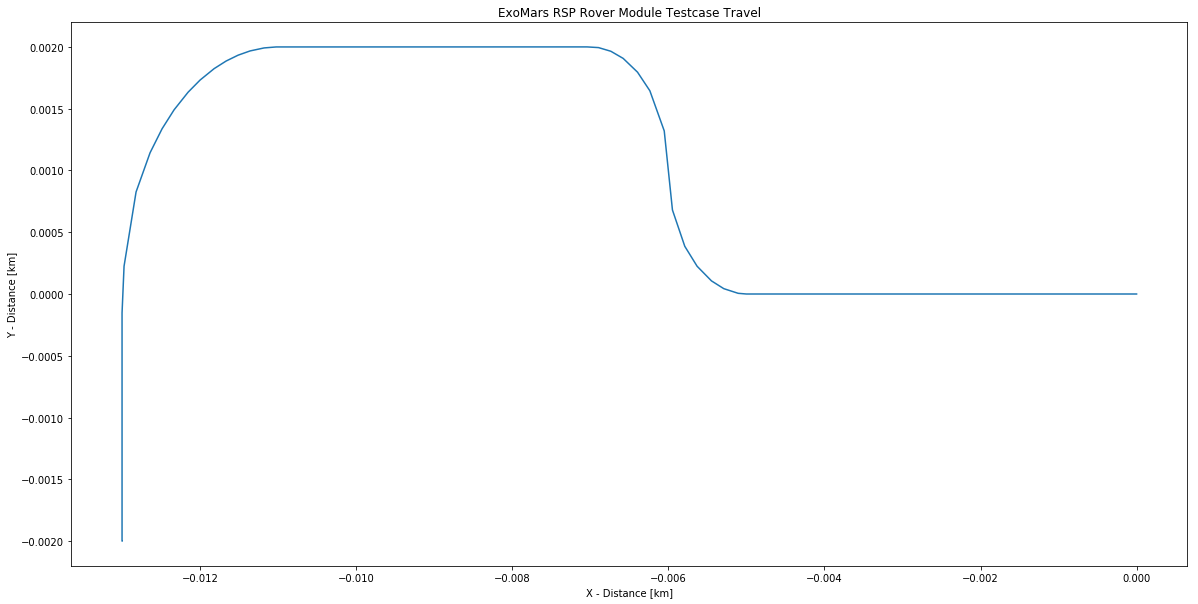

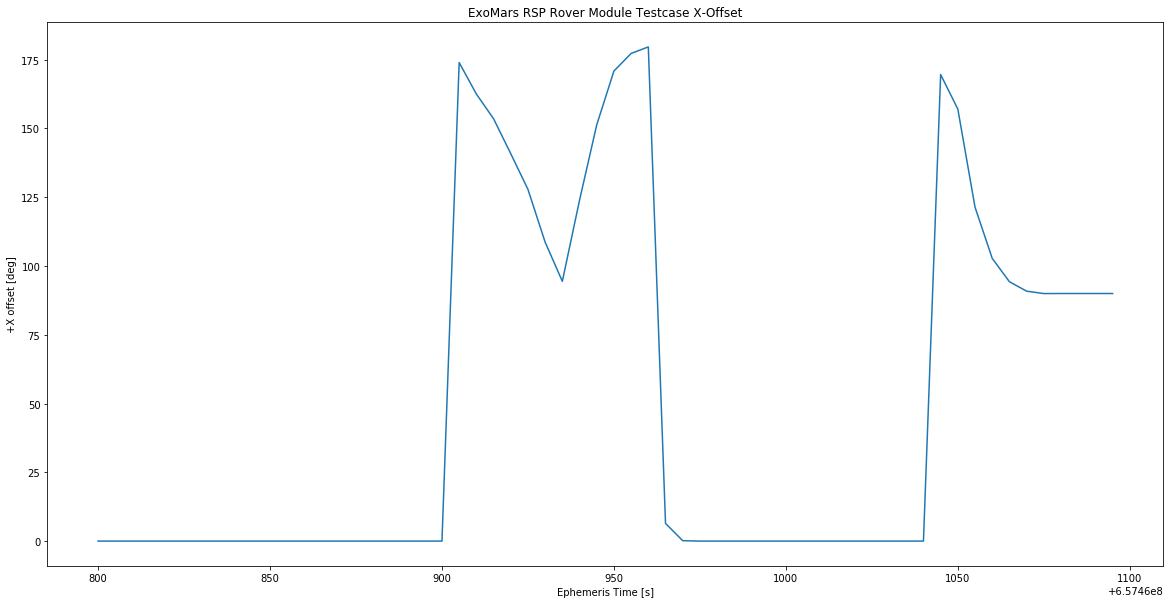

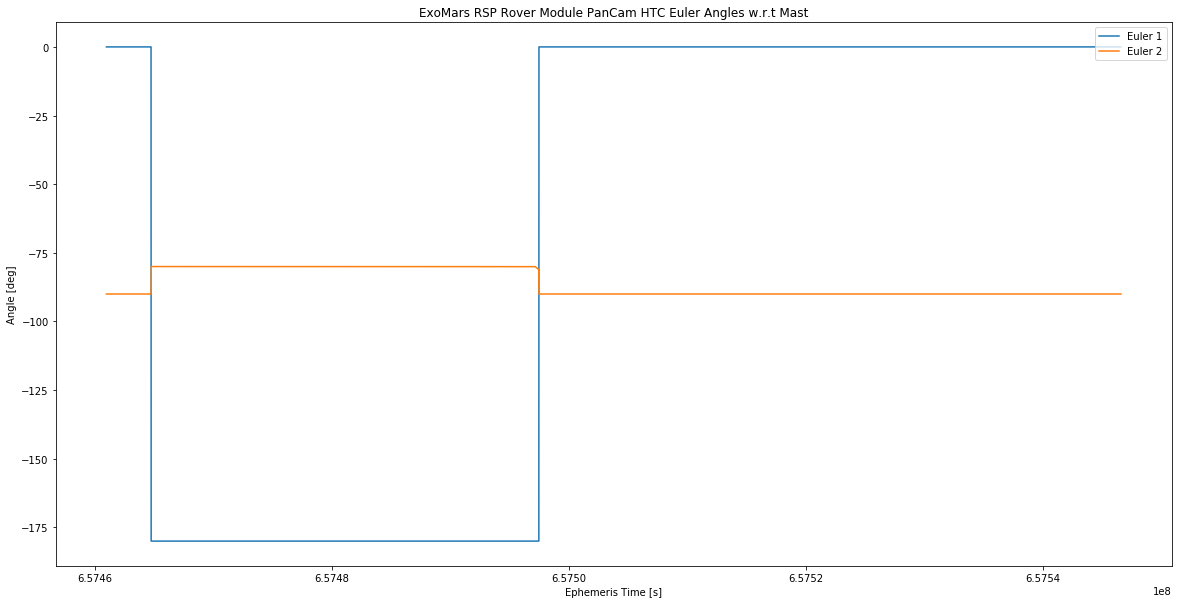

In [11]:
x, y = [], []

for element in rm_state:
    x.append(element[0])
    y.append(element[1])

fig = plt.figure()

plt.plot(x,y)
plt.title('ExoMars RSP Rover Module Testcase Travel')
plt.ylabel('Y - Distance [km]')
plt.xlabel('X - Distance [km]')
plt.show()

fig = plt.figure()

plt.plot(interval_rm,rm_xoffset)
plt.title('ExoMars RSP Rover Module Testcase X-Offset')
plt.ylabel('+X offset [deg]')
plt.xlabel('Ephemeris Time [s]')
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(interval_htc,pancam_hrc_euler_1, label='Euler 1')
ax1.plot(interval_htc,pancam_hrc_euler_2, label='Euler 2')
plt.title('ExoMars RSP Rover Module PanCam HTC Euler Angles w.r.t Mast')
plt.legend(loc='upper right');
plt.ylabel('Angle [deg]')
plt.xlabel('Ephemeris Time [s]')
plt.show()